In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Função para aplicar equalização aleatória
def random_equalization(y, sr, n_bands=5, max_gain_db=12):
    # Cria um filtro de equalização aleatório
    frequencies = np.linspace(0, sr // 2, n_bands + 2)
    gains_db = np.random.uniform(-max_gain_db, max_gain_db, n_bands + 2)
    gains_linear = 10 ** (gains_db / 20)

    # Aplica o filtro
    y_eq = np.zeros_like(y)
    for i in range(len(frequencies) - 1):
        y_band = librosa.effects.preemphasis(y, coef=gains_linear[i])
        y_eq += y_band

    return y_eq

# Função para extrair MFCCs do áudio
def extract_features(y, sr):
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)  # Retorna a média dos coeficientes
    except Exception as e:
        print(f"Erro ao extrair MFCCs: {e}")
        return None

# Função para carregar dados e aplicar equalização aleatória
def load_data_with_random_equalization(folder_path, label):
    data = []
    labels = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Extrair features do áudio original
            features = extract_features(y, sr)
            if features is not None:
                data.append(features)
                labels.append(label)

            # Aplicar equalização aleatória
            y_eq = random_equalization(y, sr)
            features_eq = extract_features(y_eq, sr)

            if features_eq is not None:
                data.append(features_eq)
                labels.append(label)

        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

    return data, labels

In [ ]:
# Definir caminhos dos áudios
file_path_real = '/content/drive/MyDrive/audios_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/fake'

# Criar diretórios se não existirem
os.makedirs(file_path_real, exist_ok=True)
os.makedirs(file_path_fake, exist_ok=True)

# Carregar dados com ruído
data_real, labels_real = load_data_with_random_equalization(file_path_real, label=1)  # Áudios reais
data_fake, labels_fake = load_data_with_random_equalization(file_path_fake, label=0)  # Áudios falsos

# Unir dados reais e falsos
data = data_real + data_fake
labels = labels_real + labels_fake

# Remover valores None
data_filtered, labels_filtered = zip(*[(d, l) for d, l in zip(data, labels) if d is not None])

In [ ]:
# Criar DataFrame
df = pd.DataFrame(data_filtered)
df['label'] = labels_filtered

In [ ]:
df.shape

(2630, 14)

In [ ]:
df['label'].unique()

array([1, 0])

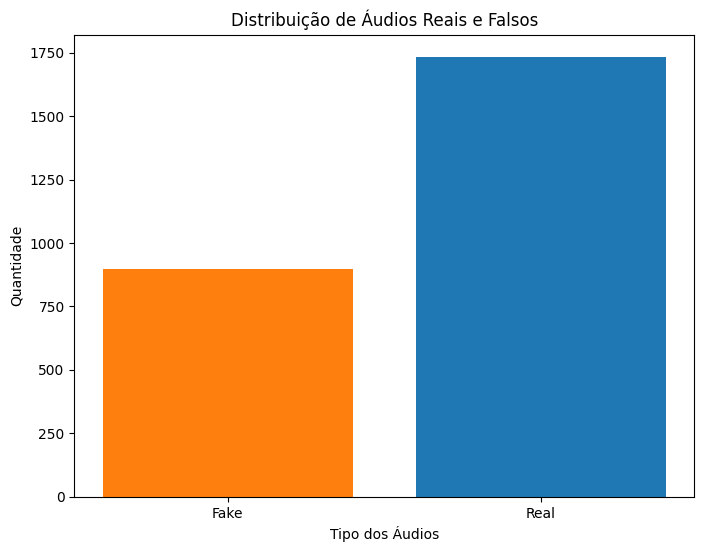

In [ ]:
# Visualizar distribuição dos rótulos
plt.figure(figsize=(8, 6))
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, tick_label=['Real', 'Fake'], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Tipo dos Áudios')
plt.ylabel('Quantidade')
plt.title('Distribuição de Áudios Reais e Falsos')
plt.show()

In [ ]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modelos
models = {
    "XGBoost": XGBClassifier(n_estimators=2, verbose=-1),
    "LGBM": LGBMClassifier(n_estimators=2, verbose=-1),
    "RandomForest": RandomForestClassifier(n_estimators=2, max_depth=2),
    "SVM": SVC(kernel='linear', probability=False)
}

# Treinar e avaliar modelos clássicos
for name, model in models.items():
    print(f"Treinando e avaliando {name}:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("-" * 30)

Treinando e avaliando RandomForest:
Acurácia: 0.92
Precisão: 0.91
Recall: 0.97
F1-Score: 0.94
--------------------------------------------------
Treinando e avaliando KNeighbors:
Acurácia: 0.88
Precisão: 0.92
Recall: 0.89
F1-Score: 0.91
--------------------------------------------------
Treinando e avaliando XGBoost:
Acurácia: 0.93
Precisão: 0.93
Recall: 0.97
F1-Score: 0.95
--------------------------------------------------
Treinando e avaliando LGBM:
Acurácia: 0.94
Precisão: 0.93
Recall: 0.97
F1-Score: 0.95
--------------------------------------------------
Treinando e avaliando DecisionTree:
Acurácia: 0.85
Precisão: 0.88
Recall: 0.91
F1-Score: 0.89
--------------------------------------------------


In [ ]:
# Modelo CNN simplificado
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(13, 1)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilando o modelo
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Ajustando os dados para a CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# Treinamento
cnn_model.fit(X_train_cnn, y_train, epochs=2, batch_size=3, verbose=1)

# Avaliação do modelo
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_cnn)
precision = precision_score(y_test, y_pred_cnn, zero_division=0)
recall = recall_score(y_test, y_pred_cnn, zero_division=0)
f1 = f1_score(y_test, y_pred_cnn, zero_division=0)

print("Treinando e avaliando CNN Simplificada:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("-" * 30)